In [2]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [3]:
TRAIN_DIR = 'emotion_dataset/train'
TEST_DIR = 'emotion_dataset/test'

In [4]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [5]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

angry completed
calm completed
happy completed
sad completed


In [6]:
print(train)

                                                   image  label
0      emotion_dataset/train\angry\Training_10118481.jpg  angry
1      emotion_dataset/train\angry\Training_10120469.jpg  angry
2      emotion_dataset/train\angry\Training_10161559.jpg  angry
3       emotion_dataset/train\angry\Training_1021836.jpg  angry
4      emotion_dataset/train\angry\Training_10269675.jpg  angry
...                                                  ...    ...
15776    emotion_dataset/train\sad\Training_99922913.jpg    sad
15777    emotion_dataset/train\sad\Training_99943858.jpg    sad
15778    emotion_dataset/train\sad\Training_99950687.jpg    sad
15779    emotion_dataset/train\sad\Training_99987906.jpg    sad
15780    emotion_dataset/train\sad\Training_99996831.jpg    sad

[15781 rows x 2 columns]


In [7]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

angry completed
calm completed
happy completed
sad completed


In [8]:
print(test)
print(test['image'])

                                                  image  label
0     emotion_dataset/test\angry\PrivateTest_1013136...  angry
1     emotion_dataset/test\angry\PrivateTest_1030447...  angry
2     emotion_dataset/test\angry\PrivateTest_1054527...  angry
3     emotion_dataset/test\angry\PrivateTest_1059009...  angry
4     emotion_dataset/test\angry\PrivateTest_1109992...  angry
...                                                 ...    ...
3764   emotion_dataset/test\sad\PublicTest_90402522.jpg    sad
3765   emotion_dataset/test\sad\PublicTest_90423571.jpg    sad
3766   emotion_dataset/test\sad\PublicTest_90433770.jpg    sad
3767   emotion_dataset/test\sad\PublicTest_90439656.jpg    sad
3768   emotion_dataset/test\sad\PublicTest_90532579.jpg    sad

[3769 rows x 2 columns]
0       emotion_dataset/test\angry\PrivateTest_1013136...
1       emotion_dataset/test\angry\PrivateTest_1030447...
2       emotion_dataset/test\angry\PrivateTest_1054527...
3       emotion_dataset/test\angry\PrivateTes

In [9]:
from tqdm.notebook import tqdm

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale =  True )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [11]:
train_features = extract_features(train['image']) 

  0%|          | 0/15781 [00:00<?, ?it/s]

C:\Users\aadha\anaconda3\Lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/3769 [00:00<?, ?it/s]

In [13]:
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [16]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [17]:
y_train = to_categorical(y_train,num_classes = 4)
y_test = to_categorical(y_test,num_classes = 4)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Optimizer
optimizer = Nadam()

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model checkpoints
checkpoint = ModelCheckpoint("./emotion_naveen.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, fill_mode='nearest')


In [22]:
# Assuming x_train, y_train, x_test, and y_test are your training and testing data
history = model.fit(datagen.flow(x_train, y_train, batch_size=48), 
                    steps_per_epoch=len(x_train) / 48, 
                    epochs=60, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks_list)

Epoch 1/60
329/328 [==============================] - ETA: 0s - loss: 1.6452 - accuracy: 0.2664
Epoch 1: val_accuracy improved from -inf to 0.25285, saving model to .\emotion_naveen.h5


C:\Users\aadha\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


328/328 [==============================] - 536s 2s/step - loss: 1.6452 - accuracy: 0.2664 - val_loss: 1.3874 - val_accuracy: 0.2529 - lr: 0.0010
Epoch 2/60
329/328 [==============================] - ETA: 0s - loss: 1.3907 - accuracy: 0.2874
Epoch 2: val_accuracy improved from 0.25285 to 0.29398, saving model to .\emotion_naveen.h5
328/328 [==============================] - 563s 2s/step - loss: 1.3907 - accuracy: 0.2874 - val_loss: 1.3686 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 3/60
329/328 [==============================] - ETA: 0s - loss: 1.3772 - accuracy: 0.2967
Epoch 3: val_accuracy improved from 0.29398 to 0.33298, saving model to .\emotion_naveen.h5
328/328 [==============================] - 597s 2s/step - loss: 1.3772 - accuracy: 0.2967 - val_loss: 1.3668 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 4/60
329/328 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.3393
Epoch 4: val_accuracy improved from 0.33298 to 0.40435, saving model to .\emotion_naveen.h5
3

Epoch 27/60
329/328 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.7136
Epoch 27: val_accuracy did not improve from 0.69621
328/328 [==============================] - 623s 2s/step - loss: 0.7213 - accuracy: 0.7136 - val_loss: 0.7511 - val_accuracy: 0.6872 - lr: 2.0000e-04
Epoch 28/60
329/328 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7176
Epoch 28: val_accuracy did not improve from 0.69621

Epoch 28: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
328/328 [==============================] - 637s 2s/step - loss: 0.7155 - accuracy: 0.7176 - val_loss: 0.7482 - val_accuracy: 0.6943 - lr: 2.0000e-04
Epoch 29/60
329/328 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.7306
Epoch 29: val_accuracy improved from 0.69621 to 0.70682, saving model to .\emotion_naveen.h5
328/328 [==============================] - 626s 2s/step - loss: 0.6859 - accuracy: 0.7306 - val_loss: 0.7186 - val_accuracy: 0.7068 - l

In [23]:
model.save("./emotion_naveen.h5")

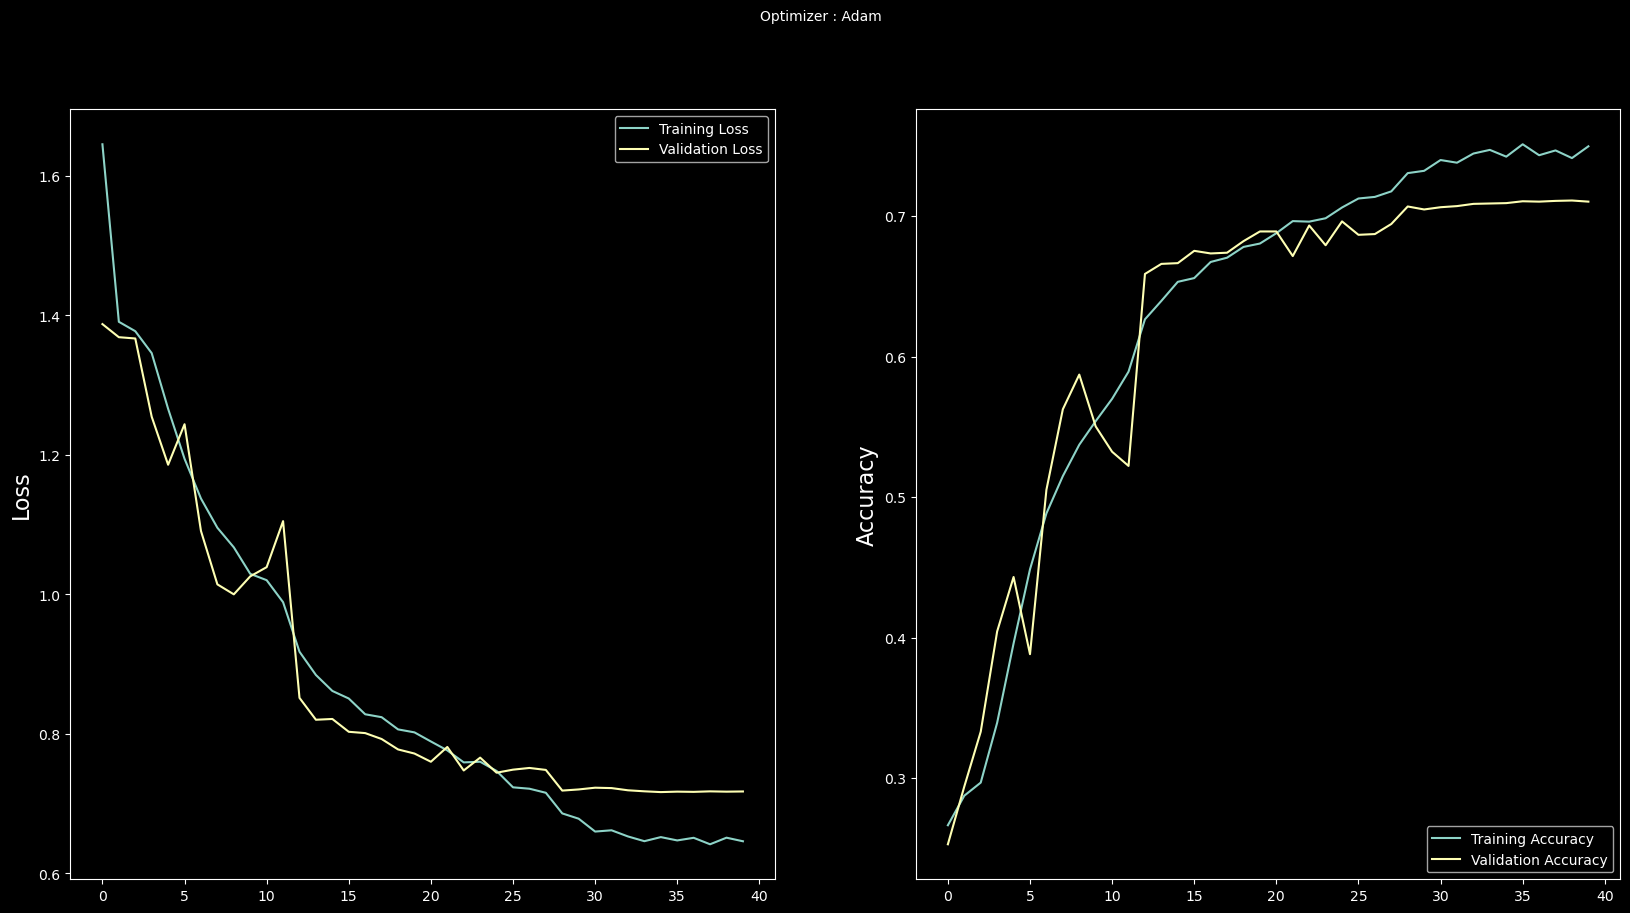

In [23]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()